DM task analysis for figure 3 (and Extended 7a).

In [ ]:
from low_rank_rnns import helpers, rdm, rankone, clustering
from low_rank_rnns.modules import *


In [2]:
helpers.setup_matplotlib()

In [3]:
col1 = 'indianred'
col2 = 'royalblue'
col_stim_period = 'silver'
col_response_period = 'sandybrown'

In [4]:
def time_mapping(t):
    return t * rdm.deltaT / 1000

In [5]:
hidden_size = 512
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = rdm.generate_rdm_data(1000)
net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, train_wi=False, train_wo=False, rank=1)
net.load_state_dict(torch.load(f'../models/rdm_lr_fig2.pt', map_location='cpu'))

In [6]:
loss_orig, acc_orig = rdm.test_rdm(net, x_val, y_val, mask_val)
print(loss_orig, acc_orig)

0.0007926790276542306 1.0


In [7]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi = net.wi_full[0].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()

m = -m
n = -n

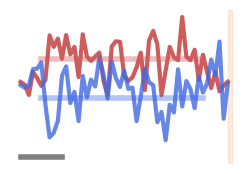

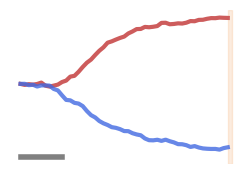

In [8]:
# Panel 3a

coh1 = 1
coh2 = -1
net.noise_std = noise_std

# Generate data and network response
x1, y1, mask1, _, _, _ = rdm.generate_rdm_data(1, coherences=[coh1], fraction_validation_trials=0.)
x2, y2, mask2, _, _, _ = rdm.generate_rdm_data(1, coherences=[coh2], fraction_validation_trials=0.)
outp1, trajectories = net.forward(x1, return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates1 = np.tanh(trajectories)
outp2, trajectories = net.forward(x2, return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates2 = np.tanh(trajectories)
outp1 = outp1.detach().squeeze().numpy()
outp2 = outp2.detach().squeeze().numpy()

# Task epochs
task_len = x1.shape[1]
stim_beg = rdm.fixation_duration_discrete
stim_end = rdm.stimulus_end
decision_beg = rdm.response_begin
time = time_mapping(np.arange(task_len))

fig, ax = plt.subplots(figsize=(3, 2))

# input
x1 = x1.squeeze().numpy()
x2 = x2.squeeze().numpy()
ax.plot(time, x1, c=col1, lw=3)
ax.plot(time, x2, c=col2, lw=3, alpha=.8)
ax.plot(time[stim_beg:stim_end], [coh1 * rdm.SCALE] * (stim_end - stim_beg), alpha=.4, lw=4, c=col1)
ax.plot(time[stim_beg:stim_end], [coh2 * rdm.SCALE] * (stim_end - stim_beg), alpha=.4, c=col2, lw=4)
ax.set_axis_off()
ax.axvspan(time_mapping(decision_beg), time_mapping(task_len), alpha=.2, color=col_response_period)
ax.set(yticks=[0], xticks=[], ylabel='input')
plt.plot([0, 0.2], [-.4, -.4], c='gray', lw=4)
# plt.savefig('figure_2/rdm_input.pdf', bbox_inches='tight')

# output
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(time, outp1, lw=3, c=col1)
ax.plot(time, outp2, lw=3, c=col2, alpha=.8)
ax.set_ylim(-1.2, 1.1)
ax.set_axis_off()
ax.axvspan(time_mapping(decision_beg), time_mapping(task_len), alpha=.2, color=col_response_period)
plt.plot([0, 0.2], [-1.1, -1.1], c='gray', lw=4)
# plt.savefig('figure_2/rdm_output.pdf', bbox_inches='tight')

(4, 152)
(4, 152, 512)


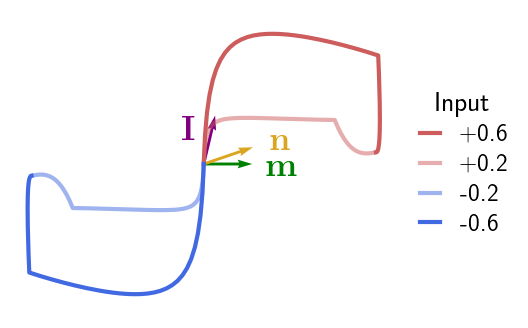

In [9]:
# Panel 3c

ymin=-.065
ymax=.065

plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(5, 4))
net.noise_std = 0.

inputs = torch.zeros((4, rdm.total_duration + 100, 1))
inputs[0, rdm.fixation_duration_discrete:rdm.stimulus_end] += .2 * rdm.SCALE
inputs[1, rdm.fixation_duration_discrete:rdm.stimulus_end] += .6 * rdm.SCALE
inputs[2, rdm.fixation_duration_discrete:rdm.stimulus_end] += -.2 * rdm.SCALE
inputs[3, rdm.fixation_duration_discrete:rdm.stimulus_end] += -.6 * rdm.SCALE
_, traj = net.forward(inputs, return_dynamics=True)
traj = net.non_linearity(traj).detach().squeeze().numpy()

i_orth = wi - (wi @ m) * m / (m @ m)
proj1 = traj @ m / (m @ m)
proj2 = traj @ i_orth / (i_orth @ i_orth)
print(proj1.shape)
print(traj.shape)
plt.plot(proj1[1], proj2[1], lw=3, label='+0.6', c=col1)
plt.plot(proj1[0], proj2[0], lw=3, label='+0.2', c=col1, alpha=.5)
plt.plot(proj1[2], proj2[2], lw=3, label='-0.2', c=col2, alpha=.5)
plt.plot(proj1[3], proj2[3], lw=3, label='-0.6', c=col2)
ax.set_ylim(ymin, ymax)

ax.set_axis_off()
ax.quiver(0, 0, 1, 0, scale=8, color='green')
ax.quiver(0, 0, wi @ m / (m @ m), wi @ i_orth / (i_orth @ i_orth), scale=8, color='purple')
ax.quiver(0, 0, n @ m / (m @ m), n @ i_orth / (i_orth @ i_orth), scale=5, color='goldenrod')
ax.text(-.05, .01, '$\mathbf{I}$', size=25, color='purple')
ax.text(.14, -.005, '$\mathbf{m}$', size=25, color='green')
ax.text(.15, .006, '$\mathbf{n}$', size=25, color='goldenrod')
ax.legend(bbox_to_anchor=(1., .5), loc='center left', labelspacing=.3, handlelength=.8, title='Input', 
          fontsize=18, title_fontsize=20, frameon=False)
net.noise_std = noise_std
# plt.savefig('figure_2/rdm_trajectories.pdf', bbox_inches='tight')

In [10]:
# Resample a network
net2 = clustering.to_support_net(net, np.zeros(hidden_size))
loss, acc = rdm.test_rdm(net2, x_val, y_val, mask_val)


/var/folders/7h/v2j2xyz55vb97w4188yzs4v40000gn/T/ipykernel_85283/1987190043.py:14: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
/var/folders/7h/v2j2xyz55vb97w4188yzs4v40000gn/T/ipykernel_85283/1987190043.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode

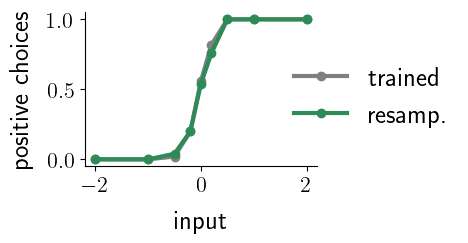

In [11]:
# Panel 3c

cohs = [-2, -1, -.5, -.2, 0., .2, .5, 1, 2]
probs_trained = []
probs_reconstructed = []
probs_res = []
fig, ax = plt.subplots(figsize=(3., 2))

# Trained net
for coh in cohs:
    input, target, mask, _, _, _ = rdm.generate_rdm_data(50, coherences=[coh], fraction_validation_trials=0)
    with torch.no_grad():
        output = net(input)
        decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
        probs_trained.append(decisions.mean().item())
        
        output = net2(input)
        decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
        probs_res.append(decisions.mean().item())
        
ax.plot(np.array(cohs), probs_res, c='gray', lw=3, label='trained', marker='o')
ax.plot(np.array(cohs), probs_trained, c='seagreen', lw=3, label='resamp.', marker='o')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0., .5, 1.])
ax.set_xlabel('input')
ax.set_ylabel('positive choices')
ax.legend(frameon=False, fontsize=19, bbox_to_anchor=(.8, .8))
# plt.savefig('figure_2/rdm_psycho.pdf', bbox_inches='tight')

(-5.011630821228027, 5.011630821228027)

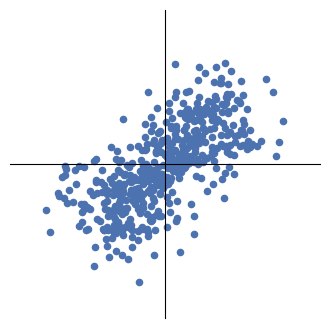

In [12]:
# Panel 3b

color = sns.color_palette('deep')[0]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(m, n, color=color, s=20)
helpers.center_axes(ax)
xlim = 1.3 * max(-np.min(m), np.max(m))
ylim = 1.3 * max(-np.min(n), np.max(n))
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)

# plt.savefig('figure_2/rdm_scatter1.pdf')

(-5.011630821228027, 5.011630821228027)

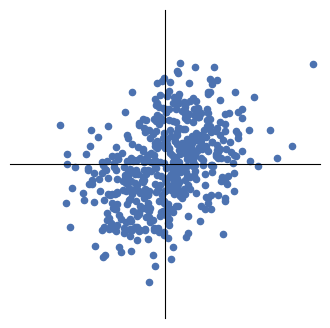

In [13]:
color = sns.color_palette('deep')[0]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(wi, n, color=color, s=20)
helpers.center_axes(ax)
xlim = 1.05 * max(-np.min(wi), np.max(wi))
ylim = 1.3 * max(-np.min(n), np.max(n))
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)

# plt.savefig('figure_2/rdm_scatter2.pdf')

[[ True False False False]
 [ True  True False False]
 [ True  True  True False]
 [ True  True  True  True]]
[[ 0.          0.90636241  0.49015319 -0.06277603]
 [ 0.          0.          1.3232739   0.72842503]
 [ 0.          0.          0.          2.44673157]
 [ 0.          0.          0.          0.        ]]


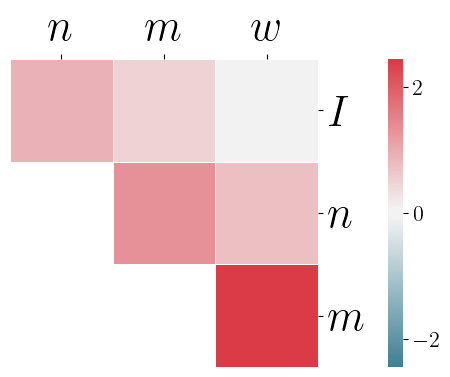

In [14]:
# SI 7a

lsize = 32
plt.rcParams['text.usetex'] = True
vectors = [wi, n, m, wo]
labels = ['$I$', '$n$', '$m$ ', '$w$']
ov = helpers.overlap_matrix(vectors)
fig, ax = plt.subplots()
helpers.get_lower_tri_heatmap(ov, cbar=True, cbar_shrink=1, cbar_pad=.15, ax=ax)
ax.set_xticks([.5, 1.5, 2.5])
ax.set_xticklabels(labels[1:])
ax.set_yticklabels(labels[:-1])
ax.xaxis.set_tick_params(labelsize=lsize)
ax.yaxis.set_tick_params(rotation=0, labelsize=lsize)
# plt.savefig('si_networks/rdm_overlap.pdf', bbox_inches='tight')